In [72]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [73]:
#reference https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html?highlight=lstm%20crf Author: Robert Guthrie
#failed to implement CRF, let's use pytoch-crf lib

from torchcrf import CRF


In [312]:
#the function copied from yjqiang 
def read_data(path, length=25000):
    sentences = []  # 每个 str 都是一个 word，List[str] 表示一个句子，List[List[str]] 表示一堆句子
    sentences_labels = []

    with open(path, 'r', encoding='UTF-8') as f:
        sentence_labels = []
        sentence = []  # List[str] 表示一个句子

        for line in f:
            line = line.strip()  # remove the newline character
            if not line:  # 空白行（表示一个句子的结束与下一个句子的开始）
                if sentence:  # 防止空白行连续多个，导致出现空白的句子
                    sentences.append(' '.join(sentence))
                    sentences_labels.append(' '.join(sentence_labels))

                    sentence = []
                    sentence_labels = []
            else:
                split_result = line.split()
                assert len(split_result) == 2
                sentence.append(split_result[0])
                sentence_labels.append(split_result[1])

        if sentence:  # 防止最后一行没有空白行，最后一句话录入不到
            sentences.append(sentence)
            sentences_labels.append(sentence_labels)
    return sentences[:length], sentences_labels[:length]

x_train, y_train = read_data("../data/conll2003/eng_bioes.train", 2000)
x_test, y_test = read_data("../data/conll2003/eng_bioes.testa", 200)

print(len(x_train), len(x_test))

2000 200


In [313]:
for i in range(5):
    print(x_train[i])
    print(y_train[i])


-DOCSTART-
O
EU rejects German call to boycott British lamb .
S-ORG O S-MISC O O O S-MISC O O
Peter Blackburn
B-PER E-PER
BRUSSELS 1996-08-22
S-LOC O
The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
O B-ORG E-ORG O O O O O O S-MISC O O O O O S-MISC O O O O O O O O O O O O O O


In [314]:
"""
x = [
    "the wall street journal reported today that apple corporation made money",
    "georgia tech is a university in georgia"
]
y = [
    "B I I I O O O B I O O",
    "B I O O O O B"
]
"""

'\nx = [\n    "the wall street journal reported today that apple corporation made money",\n    "georgia tech is a university in georgia"\n]\ny = [\n    "B I I I O O O B I O O",\n    "B I O O O O B"\n]\n'

In [315]:
#Simple Dict for embedding
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d_x = build_dict(x_train+x_test)

d_y = build_dict(y_train+y_test)

word2idx = {d_x[i]:i for i in range(len(d_x))}

tag2idx = {d_y[i]:i for i in range(len(d_y))}

tag2idx["<START>"] = 3
tag2idx["<STOP>"] = 4

pad_idx = len(word2idx)

word2idx['<pad>'] = pad_idx

tag2idx['<pad>'] = len(tag2idx)

vocab_size = len(word2idx)

n_classes = 5

print(len(word2idx))

print(tag2idx)


7199
{'B-ORG': 0, 'S-PER': 1, 'E-MISC': 2, 'I-PER': 3, 'B-MISC': 4, 'E-ORG': 5, 'I-ORG': 6, 'B-LOC': 7, 'I-MISC': 8, 'S-MISC': 9, 'I-LOC': 10, 'O': 11, 'B-PER': 12, 'E-LOC': 13, 'E-PER': 14, 'S-ORG': 15, 'S-LOC': 16, '<START>': 3, '<STOP>': 4, '<pad>': 19}


In [316]:
#Build datalodaer
batch_size = 200

class mydataset(torch.utils.data.Dataset):
    def __init__(self, x:torch.Tensor, y:torch.Tensor, length_list):
        self.x = x
        self.y = y
        self.length_list = length_list
    def __getitem__(self, index):
        data = self.x[index]
        labels = self.y[index]
        length = self.length_list[index]
        return data, labels, length
    def __len__(self):
        return len(self.x)

def get_idx(word, d):
    try:
        return d[word]
    except:
        return d['<unknown>']

def sentence2vector(sentence, d):
    return [get_idx(word, d) for word in sentence.split()]

def padding(x, max_length, d):
    length = 0
    for i in range(max_length - len(x)):
        x.append(d['<pad>'])
    return x

def get_dataloader(x, y):
    inputs = [sentence2vector(s, word2idx) for s in x]

    targets = [sentence2vector(s, tag2idx) for s in y]

    length_list = [len(i) for i in inputs]

    global max_length 
    max_length = max(max(length_list), max_length)

    inputs = torch.tensor([padding(s, max_length, word2idx) for s in inputs])

    targets =  torch.tensor([padding(s, max_length, tag2idx) for s in targets], dtype=torch.long)

    dataset = mydataset(inputs, targets, length_list)

    dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size)

    return dataloader


train_dataloader = get_dataloader(x_train, y_train)

test_dataloader = get_dataloader(x_test, y_test)


In [317]:
print(max_length)

113


In [318]:
#
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, max_length, embedding):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.target_size = len(tag_to_ix)

        if embedding:
            self.word_embeds = embedding
        else:
            self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, bidirectional=True)

        self.hidden2tag = nn.Linear(hidden_dim, self.target_size)
  
        self.crf = CRF(self.target_size)

        self.max_length = max_length

    def get_mask(self, length_list):
        mask = []
        for length in length_list:
            mask.append( [1 for i in range(length)] + [0 for j in range(self.max_length-length)] )
        return torch.tensor(mask, dtype=torch.uint8)
            
    def get_lstm_feature(self, sentences, length_list):
        
        embeds = self.word_embeds(sentences)

        packed_sentences = pack_padded_sequence(embeds, lengths=length_list, batch_first=True, enforce_sorted=False)

        lstm_out, _ = self.lstm(packed_sentences)

        result, _ = pad_packed_sequence(lstm_out, batch_first=True, total_length=self.max_length)

        feature = self.hidden2tag(result)

        return feature
    
    def forward(self, sentences, length_list, targets):
        out = self.get_lstm_feature(sentences, length_list)

        return self.crf(torch.transpose(out, 0, 1), torch.transpose(targets, 0, 1), torch.transpose(self.get_mask(length_list), 0, 1))

    def predict(self, sentences, length_list):
        out = self.get_lstm_feature(sentences, length_list)

        return self.crf.decode(torch.transpose(out, 0, 1), torch.transpose(self.get_mask(length_list), 0, 1))


In [319]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 20

net = BiLSTM_CRF(vocab_size, tag2idx, EMBEDDING_DIM, HIDDEN_DIM, max_length, None)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

for i, (inputs, targets, length_list) in enumerate(train_dataloader):
    net.zero_grad()
    
    print(inputs.size(), length_list.size(), targets.size())

    loss = net(inputs, length_list, targets)

    print(loss)

    loss.backward()

    optimizer.step()
    break


torch.Size([200, 113]) torch.Size([200]) torch.Size([200, 113])
tensor(-10010.6543, grad_fn=<SumBackward0>)


In [320]:
#Train
def pretty_time(time, degree=1):
    return str(int(time // 60)) + "m" + str(round(time % 60, degree)) if time > 60 else round(time, degree)

def train():

    optimizer = optim.Adam(net.parameters(), lr=0.005)

    epoch = 20

    start_time = time.time()

    loss_list = []

    print("dataloader length: ", len(train_dataloader))

    for i in range(epoch):
        total_loss = 0.
        for j, (inputs, targets, length_list) in enumerate(train_dataloader):

            loss = net(inputs, length_list, targets)

            net.zero_grad()
  
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            optimizer.step()

            total_loss += loss.item()
            if (j+1) % 10 == 0 and j:
                time_past = time.time() - start_time
                cur_loss = total_loss
                loss_list.append(cur_loss)
                total_loss = 0
                print("epoch: ", i, "batch: ", round(j * batch_size), " time: ", pretty_time(time_past), "loss: ", cur_loss)

    plt.plot(loss_list)

    plt.show()

dataloader length:  10
epoch:  0 batch:  1800  time:  9.5 loss:  -97533.6025390625
epoch:  1 batch:  1800  time:  17.0 loss:  -123226.82080078125
epoch:  2 batch:  1800  time:  24.5 loss:  -172303.3427734375
epoch:  3 batch:  1800  time:  32.5 loss:  -245822.22265625
epoch:  4 batch:  1800  time:  41.2 loss:  -325720.974609375
epoch:  5 batch:  1800  time:  49.9 loss:  -401264.92578125
epoch:  6 batch:  1800  time:  58.7 loss:  -472411.94921875
epoch:  7 batch:  1800  time:  1m7.5 loss:  -542778.908203125
epoch:  8 batch:  1800  time:  1m16.3 loss:  -614197.45703125
epoch:  9 batch:  1800  time:  1m25.0 loss:  -686855.79296875


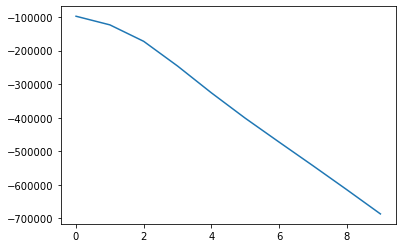

In [321]:
net = BiLSTM_CRF(len(word2idx), tag2idx, EMBEDDING_DIM, HIDDEN_DIM, max_length, None)

train()

In [323]:
def test():
    count = 0
    i = 0
    from collections import Counter
    with torch.no_grad():
        for j, (inputs, targets, length_list) in enumerate(test_dataloader):
            probs = net.predict(inputs, length_list)
            
            for u in range(len(inputs)):
                tmp = targets[u][0:length_list[u]]
                #print((torch.tensor(probs[u]) - tmp).tolist())
                i += 1
                c = (torch.tensor(probs[u]) - tmp).tolist()
                count += Counter(c)[0]

    print("acc_val: ", count / len(x_test))


In [324]:
test()

acc_val:  0.095
